# Fashion MNIST: A Multi-Class Classification Problem
We will create a multi-class CNN to solve a multi-class classification problem. Fashion MNIST is intended as a drop-in replacement for the classic MNIST dataset - a handwriting digit dataset often used as a "Hello World" dataset for machine learning. Fashion MNIST contains fashion item images, which turns out to be more challenging than MNIST.  

Fashion MNIST contains 60,000 training images and 10,000 test images, 28 x 28 pixels each, with 10 categories. 


## 0. Environment

This can be run both locally and colab. If you are going to run it locally, don't forget to create a virtual environment. Running it on colab, requires the colab extension. Then selecte kernek -> colab and go through the log in process. Colab has all major libraries installed.

## 1. Load the dataset
Keras provides some utility functions to fetch and load some commonly used datasets, including Fashin MNIST. The `load_data()` method directly splits the training and test set. 

Since the class names are not included with the dataset, store them here to use later when plotting the images.

We will explore the format of the dataset, the data type of the input images, also display a few images to have a first impression of the dataset.

In [9]:
from keras.datasets import fashion_mnist # Pip install both keras and tensor flow in the venv
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

n_classes = 10
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Inspect data
print(f" There are {X_train.shape[0]} images which are {X_train.shape[1]} x {X_train.shape[2]} pixels. These are for training.")
print(f" We also have {y_train.shape[0]} labels for each image.")
print(f" An exampe of a label for the first image is {y_train[0]} which corresponds to {class_names[y_train[0]]}")

print(f" There are {X_test.shape[0]} images which are {X_test.shape[1]} x {X_test.shape[2]} pixels. These are for testing.")

# Check that the labels are correct 
print(y_train.dtype, y_train.min(), y_train.max(), y_train.shape)

 There are 60000 images which are 28 x 28 pixels. These are for training.
 We also have 60000 labels for each image.
 An exampe of a label for the first image is 9 which corresponds to Ankle boot
 There are 10000 images which are 28 x 28 pixels. These are for testing.
uint8 0 9 (60000,)


## 2. Prepare the data
Since pixel values in an image are in the same range [0, 255], we don't need to standarize or normalize the input data as what we did for the Indian Diebetes dataset. The only thing we are suppose to do for this dataset is to scale the pixel values down to the [0,1] range by simply dividing them by 255.0 (this also converts them to floats). 

In [10]:
# For each row of data, 
X_train = X_train.astype("float32") / 255.0
X_test  = X_test.astype("float32") / 255.0

# Verify this worked
print(f"After rescaling, an examlpe of training data X-axis pixes are: {X_train[5][0]}")

After rescaling, an examlpe of training data X-axis pixes are: [0.         0.         0.         0.         0.00392157 0.
 0.         0.         0.         0.08627451 0.34509805 0.7372549
 0.6745098  0.5176471  0.49019608 0.5529412  0.78039217 0.56078434
 0.03529412 0.         0.         0.         0.00392157 0.
 0.         0.         0.         0.        ]


### 2.1 Augment the data

We are going to apply data augmentation to make out small dataset larger. This means that we are generating synthetic data from existing training examples by augmenting the samples via a number of random transformations. 

Types of transofmrations: 

Geometric: flip, rotate, shift, zoom ,crop
Photometric: brightness, contrast, color, blur


In principle, mimic realistic variations the model will see in deployment. 

You only augment X not Y. 
Also, don't augment it too much so that the Y should change. For example roate 6 by 180deg and it becomes a 9. 

#### Option 1: Apply augmentation inside the model (layer). THIS IS WHAT I WILL DO

The benefit is that augmentation is GPU accelerated. 
Augmentation IS ONLY APPLIED TO TRAINING DATA. Not validation or test. 
Every batch is randomly augmented
Every epoch sees different versions of the same images. 

#### Option 2: Apply augmentation in the data pipeline 

The benefit is that the model architecture doesn't change. We can expriment with transofrmations without actually changing the architecture. 

In [11]:
from keras import layers, Sequential

# Define the data augmentation layer
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"), # Flip left-right
    layers.RandomRotation(0.2), # Rotate by 20% of 360 degrees
    layers.RandomZoom(0.1), # Zoom in/out +- 10%
    layers.RandomTranslation(0.1, 0.1), # Shift in height/width +- 10%
    layers.RandomShear(0.1) # Shear transformation +-10%
])


## 3. Build the convolutional neural network 
Before, I built a NN for this task. But now I am adding convolutional layers to preserve the spatial layout and learn local patterns. 

This is a simple CNN:

1) Conv-1 layer: 32 filters with size 3 x 3, a stride of 1, and ReLU activation function. Each output feature map must be the same size as the input image size (28 x 28). I am not using larger kernels because they have more parameters and are more prone to overfitting. Since I am using more than 1 Kernel, despite it being small, they will have the same recepting field. I am adding the Relu activation to introduce non linearity. It will turn all negative values to zero. They also help adress vanishing gradients problem . Note: There is just 1 channel as it is grayscale. 
2) Maxpooling-1 layer: filter size 2 x 2, a stride of 2. This one keeps the maximum value in each 2x2 square. The result is effectively a feature map which is reduced by a factor of 2 in H and W than the Conv layer. 
3) Conv-2 layer: 64 filters with size 3 x 3, a stride of 1, no padding and ReLU activation function. Here we are trying to detect larger patterns. from the previos feature map. 
4) A flatten layer to act as the input to the classifier portion of hte CNN
5) Dense layer: 64 neurons with ReLU activation function.
6) The output layer. This is a 10 neuros (same number as classe) with softmax since we already normalised the grayscale to 0-1

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

model = Sequential()


# Input layer
model.add(layers.Input(shape=(28, 28, 1)))

# Data augmentation layer (training only)
model.add(data_augmentation)

# 1st Layer - `Conv2D'
model.add(Conv2D(32, (3,3), activation = 'relu'))

# 2nd layer - Max pooling layer. 
model.add(MaxPooling2D(2,2))

# 3rd layer - 'Conv2D'
model.add(Conv2D(64, (3,3), activation = 'relu'))

# 4th layer - Flatten
model.add(Flatten())

# 5th Layer - Dense
model.add(Dense(64, activation = 'relu'))

# 6th layer - Output
model.add(Dense(10, activation = 'softmax'))

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       495,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 515,146 (1.97 MB)

 Trainable params: 515,146 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Compile the model
The typical loss function for a multi-class problem is the multi-class cross-entropy loss function. In Keras, there are two options. One is to use the `sparse_categorical_crossentropy` loss with the original sparse labels (i.e., for each image, there is just one actual class index, from 0 to 9 in this case). The other is to use `categorical_crossentropy` loss if the actual output is a one-hot vector (e.g., [0, 0, 1, 0, ...., 0]). In this case, we will need to first convert the current sparse label (i.e., class index) to one-hot vecore labels by using `keras.utils.to_categorical()` method.

In [13]:
# Remember that in y_train, we have labels like y_train[0] =2. So with the sparse categorical cross entropy,
# Keras internally, will take the softmax output, and look at the probability of class 2 and it will compute the cross entropy loss. 

model.compile(
    loss = "sparse_categorical_crossentropy", 
    optimizer = 'adam', # This is not SGD, or Momentum, it increases learning rate when slope is reliable and slows it down when noisy. THIS IS ADAPTIVE LEARNING RATE
    metrics = ['accuracy'] # accuracy = (number of correct predictions) / (total predictions)
)

## 5. Train and validate the model
We use a validation set to moniter your model. We also draw the learning curve on the training and validation sets, to see how your model is learnt and how it generalises to new data, then try to adjust our model and add any regularization techniques accordingly till we are satisfied.

In [ ]:
# Firstly, lets create a checkpoint where we store the best model obtained during training.
# We watch validation accurace and save the model when it improves. 
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'fashion_mnist_best.h5', # Where to save the mode
    monitor='val_accuracy', # Which variable to measure
    save_best_only=True, # Only save when the variable improves
    mode='max', # Success is when the metric increases
    verbose=1 # Display messages 
)

callbacks = [checkpoint] # Store each checkpoint in a list

# Now we train the model

print('Starting training...')
# train the model, store the results for plotting
history = model.fit(
    X_train, y_train,
    validation_split=0.2,   # 20% of training used as validation
    epochs=50, # Epoch  = one full pass through the training dataset. `too few = underfitting, too many = overfitting`
    batch_size=128, # Insead of going throuigh 60000 * 0.8 (remmebr train split) images, we group them in groups of 128 so for 1 epoch, the model will update its weights 60000*0.8/128 times
    callbacks=callbacks,
    verbose = "auto"
)

Starting training...
Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4638 - loss: 1.4828
Epoch 1: val_accuracy improved from -inf to 0.59683, saving model to fashion_mnist_best.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 29s 73ms/step - accuracy: 0.4641 - loss: 1.4821 - val_accuracy: 0.5968 - val_loss: 1.2406
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6633 - loss: 0.9506
Epoch 2: val_accuracy improved from 0.59683 to 0.62700, saving model to fashion_mnist_best.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 72ms/step - accuracy: 0.6633 - loss: 0.9505 - val_accuracy: 0.6270 - val_loss: 1.2128
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7099 - loss: 0.8112
Epoch 3: val_accuracy improved from 0.62700 to 0.67258, saving model to fashion_mnist_best.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 40s 70ms/step - accuracy: 0.7099 - loss: 0.8112 - val_accuracy: 0.6726 - val_loss: 1.0621
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7371 - loss: 0.7386
Epoch 4: val_accuracy improved from 0.67258 to 0.69267, saving model to fashion_mnist_best.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step - accuracy: 0.7371 - loss: 0.7386 - val_accuracy: 0.6927 - val_loss: 0.9580
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7540 - loss: 0.6906
Epoch 5: val_accuracy improved from 0.69267 to 0.70942, saving model to fashion_mnist_best.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 27s 71ms/step - accuracy: 0.7541 - loss: 0.6906 - val_accuracy: 0.7094 - val_loss: 0.8868
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7685 - loss: 0.6548
Epoch 6: val_accuracy improved from 0.70942 to 0.73633, saving model to fashion_mnist_best.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 70ms/step - accuracy: 0.7685 - loss: 0.6548 - val_accuracy: 0.7363 - val_loss: 0.8276
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7795 - loss: 0.6241
Epoch 7: val_accuracy improved from 0.73633 to 0.76708, saving model to fashion_mnist_best.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step - accuracy: 0.7795 - loss: 0.6241 - val_accuracy: 0.7671 - val_loss: 0.7249
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7875 - loss: 0.5981
Epoch 8: val_accuracy did not improve from 0.76708
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 73ms/step - accuracy: 0.7875 - loss: 0.5981 - val_accuracy: 0.7001 - val_loss: 0.8855
Epoch 9/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7840 - loss: 0.5931
Epoch 9: val_accuracy did not improve from 0.76708
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 72ms/step - accuracy: 0.7841 - loss: 0.5931 - val_accuracy: 0.7497 - val_loss: 0.7254
Epoch 10/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7956 - loss: 0.5713
Epoch 10: val_accuracy did not improve from 0.76708
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 72ms/step - accuracy: 0.7956 - loss: 0.5713 - val_accuracy: 0.7548 - val_loss: 0.7334
Epoch 11/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8020 - loss: 0.5540
Epoch 11: val_accura

375/375 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step - accuracy: 0.8020 - loss: 0.5540 - val_accuracy: 0.7933 - val_loss: 0.6064
Epoch 12/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8078 - loss: 0.5446
Epoch 12: val_accuracy did not improve from 0.79333
375/375 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step - accuracy: 0.8078 - loss: 0.5446 - val_accuracy: 0.7368 - val_loss: 0.8468
Epoch 13/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8126 - loss: 0.5261
Epoch 13: val_accuracy did not improve from 0.79333
375/375 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step - accuracy: 0.8126 - loss: 0.5261 - val_accuracy: 0.7444 - val_loss: 0.7215
Epoch 14/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8151 - loss: 0.5075
Epoch 14: val_accuracy did not improve from 0.79333
375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 71ms/step - accuracy: 0.8151 - loss: 0.5076 - val_accuracy: 0.7791 - val_loss: 0.6156
Epoch 15/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8122 - loss: 0.5129
Epoch 15: val_ac

375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 71ms/step - accuracy: 0.8190 - loss: 0.5043 - val_accuracy: 0.7954 - val_loss: 0.5920
Epoch 17/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8191 - loss: 0.4980
Epoch 17: val_accuracy improved from 0.79542 to 0.81783, saving model to fashion_mnist_best.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.8191 - loss: 0.4980 - val_accuracy: 0.8178 - val_loss: 0.5129
Epoch 18/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8286 - loss: 0.4817
Epoch 18: val_accuracy did not improve from 0.81783
375/375 ━━━━━━━━━━━━━━━━━━━━ 27s 71ms/step - accuracy: 0.8286 - loss: 0.4817 - val_accuracy: 0.7958 - val_loss: 0.6343
Epoch 19/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8246 - loss: 0.4931
Epoch 19: val_accuracy did not improve from 0.81783
375/375 ━━━━━━━━━━━━━━━━━━━━ 27s 71ms/step - accuracy: 0.8246 - loss: 0.4931 - val_accuracy: 0.8056 - val_loss: 0.5601
Epoch 20/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8283 - loss: 0.4737
Epoch 20: val_accuracy improved from 0.81783 to 0.81850, saving model to fashion_mnist_best.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.8283 - loss: 0.4737 - val_accuracy: 0.8185 - val_loss: 0.5166


## 6. Create the accuracy plots

Accuracy plots show how often the model predicts the correct class over time. The training accuracy indicates how well the model fits the training data, while the validation accuracy shows how well the model generalises to unseen data. Comparing the two helps identify underfitting (both accuracies low) or overfitting (training accuracy high but validation accuracy significantly lower).

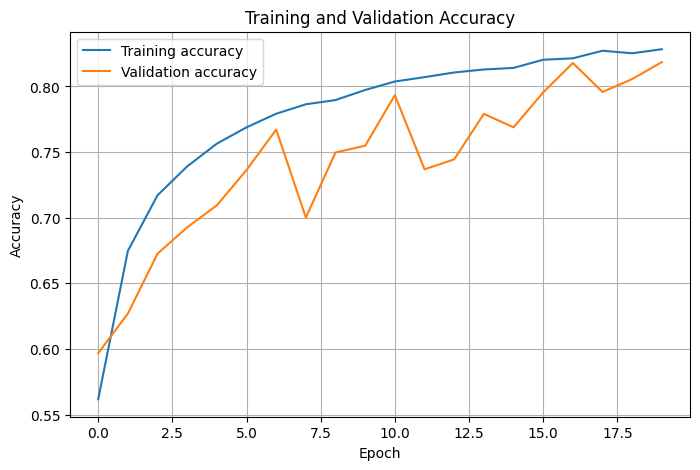

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8, 5))

plt.plot(history.history["accuracy"], label="Training accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)

plt.show()

## 7. Create the loss plots

Loss plots show how wrong the model’s predictions are and how confident those predictions are. Training loss reflects how well the model is learning the training data, while validation loss indicates how stable and reliable the model is on unseen data. Diverging loss curves—where training loss decreases but validation loss increases—are a strong sign of overfitting.

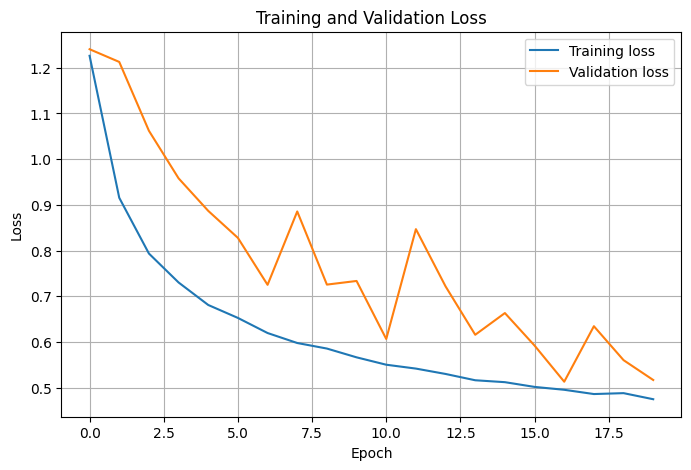

In [16]:
plt.figure(figsize=(8, 5))

plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

plt.show()

## 8. Evaluate the model
First evaluate our model on the test set to report the accuracy on the test set. Then use the `model`'s `predict()` method to make predictions on new instances. Display a few images and compare their predicting classes with their actual classes.

In [17]:
# Evalute the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Make predictions on new data
y_pred_prob = model.predict(X_test)

Test accuracy: 0.8175
Test loss: 0.5327
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


## 9. Transfer learning

There are two ways to do trasnfer learning.

#### Option 1: Feature extraction

We freeze the Pretrained convolutional base of the big model and get rid of the classifier and train a new one. 

Effectively, we are extracting features with the pre trained model (convolutional base) and train a new classifier with the input features. This classifier could be any machine learning classifier (SVM, random forests, MLP)

#### Option 2: Fine tuning (what I am doing here)

Learnt filters start from pre-trained model and are slightly adjusted. 
Fine-tune the higher layers in the convolutional base and freeze the early layers since early features are more generic. 
Use lower learning rate while fine-tuning, 1/10 of the original learning rate would be a good starting point. 



### 9.1 Define the convolutional base

Since we are fine tuning, we are adding higher layers convolutions. This means we have to define the convolutional base of our new model from the pretrained model and also specify that we want to get rid of the classifier from the pre trained model. 

In [ ]:
from keras.applications import VGG16

# Get the convolutional base

conv_base = VGG16(weights = "imagenet", # How to initialiese the model. The model is pretrained on imagenet. If none, we just get the architecture
                 include_top = False, # It means NOT including the fully connected layer
                 input_shape = (96,96,3) # Input image size. IT SHOULDN"T be smaller than 75 but unfortuantely we only have 28 by 28. It also expects 3 channels
                 )

conv_base.trainable = False # Freeze all weights in the convolutional base so they do not get updated during training. 
conv_base.summary()

### 9.2 Resize the daata from (28,28,1) to (96,96,3)

We need to resize our data because its too small and grayscale for VGC16

In [ ]:
from keras import layers, Sequential

data_transform = Sequential([
    layers.Resizing(96, 96),
    layers.Lambda(lambda x: tf.repeat(x, repeats=3, axis=-1)),  # (H,W,1) → (H,W,3)
])